<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/visualizations/Copy_of_Explore_data_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with github: [A guide from Google](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Let's take a look at the project files

First, load the Google Drive where the project files are stored. Use the file menu on the sidebar. The path to the project files must be edited below...

Install packages that are now installed by default.

In [ ]:
# Clone Gitub repository to Colab
from google.colab import drive
drive.mount('/content/drive')

!apt-get install git
!git clone https://github.com/liangchow/zindi-amazon-secret-runway.git

!pip install dbfread==2.0.7
!pip install folium

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
fatal: destination path 'zindi-amazon-secret-runway' already exists and is not an empty directory.


Import all necessary packages...

In [ ]:
# Acess to "Data Visualization" folder
%cd /content/zindi-amazon-secret-runway/Data Visualization

# Import libraries
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from dbfread import DBF

/content/zindi-amazon-secret-runway/Data Visualization


**Setup the main paths to the project files.**

These are the base paths to the folders containing on your Google Drive. You need to change these based on where you have your data uploaded in your drive.
<br>
This block also collects all .shp files from the base aoi directory.

In [ ]:
import os

airstrip_training_path = '/content/drive/MyDrive/Colab Notebooks/zindi/data/pac_2024_training/pac_2024_training.shp'
base_aoi_path = '/content/drive/MyDrive/Colab Notebooks/zindi/data/shp_test_AOIs'

aoi_paths = []

# Collect all .shp files from the base aoi directory
for filename in os.listdir(base_aoi_path):
    if filename.endswith('.shp'):
        aoi_paths.append(os.path.join(base_aoi_path, filename))

print("There are {} shape files in the area of interest directory".format(len(aoi_paths)))

There are 11 shape files in the area of interest directory


Let's take a look at the airstrip training shape file. Each record contains
columns for ***id***, ***year of detection***, ***largo*** (length probably in meters), ***Activo*** (activity status), and ***geometry*** of type Linestring with coordinates (LNG LAT) which define points along the airstrip. We open the file, print the header, some info about the columns, and plot the data.

|    |   id |   yr |    largo |   Activo | geometry                                                                                                                            |
|---:|-----:|-----:|---------:|---------:|:------------------------------------------------------------------------------------------------------------------------------------|
|  0 |    1 | 2023 |  968.918 |        0 | LINESTRING (-70.08928656863503 -13.129844039931504, -70.08052787039317 -13.128251134052485, -70.08052787039317 -13.128251134052485) |
|  1 |    2 | 2022 | 1105.49  |        0 | LINESTRING (-69.16744237255283 -13.620679758207931, -69.1728593987747 -13.612261251288524)                                          |
|  2 |    3 | 2015 |  985.018 |        0 | LINESTRING (-69.14224792429687 -13.694510447986984, -69.14189616934739 -13.685654549844925)                                         |
|  3 |    4 | 2020 |  681.914 |        0 | LINESTRING (-69.07843632939438 -13.787902019520923, -69.08404112675193 -

<Axes: >

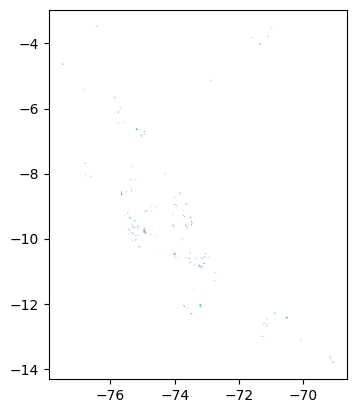

In [ ]:
# Read the shapefile
airstrip_training_gdf = gpd.read_file(airstrip_training_path)

# Display the data
print(airstrip_training_gdf.head().to_markdown(), "\n")
print(airstrip_training_gdf.info(), "\n")

# Plot the shapefile (if it contains geometric data)
airstrip_training_gdf.plot()

Let's take a look at the shapefiles representing a specific geographic area of interest. Each record in the shapefiles contain columns for ***MINX*** (minimum X-coordinate), ***MINY*** (minimum Y-coordinate), ***MAXX*** (maximum X-coordinate), ***MAXY*** (maximum Y-coordinate), ***CNTX*** (centroid X-coordinate), ***CNTY*** (centroid Y-coordinate), ***AREA*** (area of the polygon), ***PERIM*** (perimeter of the polygon), ***HEIGHT*** (height of the bounding box), ***WIDTH*** (width of the bounding box), and ***geometry*** of type Polygon. The coordinates for the polygon's vertices are listed in the ***geometry*** column, with the order being (LNG LAT).

We open the file, print the header and review some information about the columns. The areas of interest won't look good on a map until we use something like Folium.


In [ ]:
aoi_gdfs = []

# Load each AOI shapefile into a list of GeoDataFrames
for aoi_path in aoi_paths:
    aoi_gdf = gpd.read_file(aoi_path)
    aoi_gdfs.append(aoi_gdf)

print(aoi_gdfs[0].head().to_markdown(), "\n")
print(aoi_gdfs[0].info())

|    |   MINX |        MINY |   MAXX |       MAXY |   CNTX |        CNTY |        AREA |   PERIM |   HEIGHT |   WIDTH | geometry                                                                                                                                                                                       |
|---:|-------:|------------:|-------:|-----------:|-------:|------------:|------------:|--------:|---------:|--------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | 410245 | 9.28163e+06 | 425655 | 9.2969e+06 | 417950 | 9.28927e+06 | 2.35311e+08 |   61360 |    15270 |   15410 | POLYGON ((410245.3165693986 9281633.37840259, 410245.3165693986 9296903.37840259, 425655.3165693986 9296903.37840259, 425655.3165693986 9281633.37840259, 410245.3165693986 9281633.37840259)) | 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1

Here we ensure the training data and areas of interest are in [WGS84](https://epsg.io/4236) and find the center point of all airstrip training set geometries to center the map around.
<br>
We reproject to a projected coordinate reference system (CRS), in this case the [World Mercator projection](https://epsg.io/3395), before calculating centroids. We then convert the centroid back to the original geographic CRS (WGS84) to ensure the accuracy of spatial calculations. See [here](https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas) for more information.

In [ ]:
# Ensure the airstrip GeoDataFrame is in WGS84 (lat/lon) CRS
if airstrip_training_gdf.crs != "EPSG:4326":
    airstrip_training_gdf = airstrip_training_gdf.to_crs(epsg=4326)

# Reproject each AOI GeoDataFrame to WGS84 if necessary
for i in range(len(aoi_gdfs)):
    if aoi_gdfs[i].crs != "EPSG:4326":
        aoi_gdfs[i] = aoi_gdfs[i].to_crs(epsg=4326)

# Temporarily reproject to a projected CRS for accurate centroid calculation
projected_airstrip_training_gdf = airstrip_training_gdf.to_crs(epsg=3395)  # World Mercator projection

# Get the single point centroid that represents the center of the entire set of training airstrips
centroid = projected_airstrip_training_gdf.geometry.centroid.unary_union.centroid

# Convert the centroid back to WGS84 (LNG, LAT)
centroid_wgs84 = gpd.GeoSeries([centroid], crs=projected_airstrip_training_gdf.crs).to_crs(epsg=4326).geometry[0]

print(centroid_wgs84)

POINT (-74.03857211335199 -9.657457256615997)


Let's create a better map with Folium. The map will display airstrips and Areas of Interest (AOIs). Both AOIs and airstrips will be shown with tooltips displaying their IDs and popups showing additional attributes. <br>
In order for airstrips to be clickable over the areas of interest, it's important to render them after the AOIs.



***1. Setting Up the Map*** <br>
We begin by creating a folium.Map object centered around the calculated centroid of the airstrips. This map will serve as the canvas where we will plot both the airstrips and AOIs.

In [ ]:
# You can use custom tiles like so (https://python-visualization.github.io/folium/latest/user_guide/raster_layers/tiles.html)
# Create a Folium map
m = folium.Map(
    location=[centroid_wgs84.y, centroid_wgs84.x],
    zoom_start=8,
    scrollWheelZoom=False,
)

***2. Defining Popup Content***<br>
Here we define two functions to create the content for the popups: one for the airstrips and one for the AOIs. These functions format the attributes of each feature into a readable string using HTML.

In [ ]:
# Function to create a popup with airstrip attributes
def create_airstrip_popup_content(row):
    return (
        f"ID: {row['id']}<br>"
        f"Year: {row['yr']}<br>"
        f"Length: {row['largo']} meters<br>"
        f"Active: {'Yes' if row['Activo'] == 1 else 'No'}"
    )

# Function to create a popup with AOI attributes
def create_aoi_popup_content(row):
    return (
        f"MINX: {row['MINX']}<br>"
        f"MINY: {row['MINY']}<br>"
        f"MAXX: {row['MAXX']}<br>"
        f"MAXY: {row['MAXY']}<br>"
        f"AREA: {row['AREA']} square units<br>"
        f"PERIMETER: {row['PERIM']} units"
    )


***3. Adding AOIs to the Map***<br>
The AOIs are added first so that they appear behind the airstrips on the map. Each AOI is represented by a polygon with an associated popup showing its attributes. The AOIs can be styled as you wish. The styling can be powerful, so look into it briefly. See [here](https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html#Styling) for more info.

In [ ]:
# Add each AOI GeoDataFrame to the map first to render them behind airstrips
for i, aoi_gdf in enumerate(aoi_gdfs):
    for _, row in aoi_gdf.iterrows():
        # Create a GeoJSON feature from the AOI row
        geojson_feature = {
            'type': 'Feature',
            'properties': row.drop('geometry').to_dict(),
            'geometry': row['geometry'].__geo_interface__
        }

        # Create a Folium Popup with the formatted AOI attributes
        aoi_popup_content = create_aoi_popup_content(row)
        aoi_popup = folium.Popup(aoi_popup_content, max_width=300)

        # Add AOI to the map with GeoJson, tooltips, and popups
        folium.GeoJson(
            geojson_feature,
            name=f'AOI {i+1}',
            tooltip=folium.Tooltip(f"AOI {i+1}"),
            popup=aoi_popup,
            style_function=lambda feature: {
                "fillColor": "#ff7800",
                "color": "red",
                "weight": 2,
            },
        ).add_to(m)

***4. Adding Airstrips to the Map***<br>
After the AOIs, the airstrips are added on top. Each airstrip is displayed with a tooltip that shows its ID when hovered over, and a popup that shows some attributes when clicked.

In [ ]:
# Add the airstrip training shapefile to the map with GeoJson, tooltips, and popups
for _, row in airstrip_training_gdf.iterrows():
    # Create a GeoJSON feature from the row
    geojson_feature = {
        'type': 'Feature',
        'properties': row.drop('geometry').to_dict(),
        'geometry': row['geometry'].__geo_interface__
    }

    # Create a Folium Popup with the formatted attributes
    popup_content = create_airstrip_popup_content(row)
    popup = folium.Popup(popup_content, max_width=300)

    # Create a Folium GeoJson object and add it to the map
    folium.GeoJson(
        geojson_feature,
        name=f"Airstrip {row['id']}",
        tooltip=folium.Tooltip(f"ID: {row['id']}"),
        popup=popup,
        style_function=lambda feature: {
            "fillColor": "#ffff00",
            "color": "black",
            "weight": 3,
        },
    ).add_to(m)


***5. Adding Layer Controls***<br>
Finally, a layer control is added to the map, allowing users to toggle the visibility of the AOIs and airstrips on and off. You'll notice in the code blocks above that we have given names to each GeoJSON object we added to the map. These are the names that will appear in the legend and when we mouse over the objects.

In [ ]:
# Add a layer control to toggle the AOIs and runway on/off
folium.LayerControl().add_to(m)

***6. Displaying the Map***<br>
This one's a doozy.

In [ ]:
m
# or call display(m)

We've combined all the map making steps above into one big code block here, so feel free fiddle around here withotu needing to run a million code blocks again.

In [ ]:
# Create a Folium map
m = folium.Map(
    location=[centroid_wgs84.y, centroid_wgs84.x],
    zoom_start=6,
    scrollWheelZoom=False,
)

# Function to create a popup with airstrip attributes
def create_airstrip_popup_content(row):
    return (
        f"ID: {row['id']}<br>"
        f"Year: {row['yr']}<br>"
        f"Length: {row['largo']} meters<br>"
        f"Active: {'Yes' if row['Activo'] == 1 else 'No'}"
    )

# Function to create a popup with AOI attributes
def create_aoi_popup_content(row):
    return (
        f"MINX: {row['MINX']}<br>"
        f"MINY: {row['MINY']}<br>"
        f"MAXX: {row['MAXX']}<br>"
        f"MAXY: {row['MAXY']}<br>"
        f"AREA: {row['AREA']} square units<br>"
        f"PERIMETER: {row['PERIM']} units"
    )

# Add each AOI GeoDataFrame to the map first to render them behind airstrips
for i, aoi_gdf in enumerate(aoi_gdfs):
    for _, row in aoi_gdf.iterrows():
        # Create a GeoJSON feature from the AOI row
        geojson_feature = {
            'type': 'Feature',
            'properties': row.drop('geometry').to_dict(),
            'geometry': row['geometry'].__geo_interface__
        }

        # Create a Folium Popup with the formatted AOI attributes
        aoi_popup_content = create_aoi_popup_content(row)
        aoi_popup = folium.Popup(aoi_popup_content, max_width=300)

        # Add AOI to the map with GeoJson, tooltips, and popups
        folium.GeoJson(
            geojson_feature,
            name=f'AOI {i+1}',
            tooltip=folium.Tooltip(f"AOI {i+1}"),
            popup=aoi_popup,
            style_function=lambda feature: {
                "fillColor": "#ff7800",
                "color": "red",
                "weight": 2,
            },
        ).add_to(m)

# Add the airstrip training shapefile to the map with GeoJson, tooltips, and popups
for _, row in airstrip_training_gdf.iterrows():
    # Create a GeoJSON feature from the row
    geojson_feature = {
        'type': 'Feature',
        'properties': row.drop('geometry').to_dict(),
        'geometry': row['geometry'].__geo_interface__
    }

    # Create a Folium Popup with the formatted attributes
    popup_content = create_airstrip_popup_content(row)
    popup = folium.Popup(popup_content, max_width=300)

    # Create a Folium GeoJson object and add it to the map
    folium.GeoJson(
        geojson_feature,
        name=f"Airstrip {row['id']}",
        tooltip=folium.Tooltip(f"ID: {row['id']}"),
        popup=popup,
        style_function=lambda feature: {
            "fillColor": "#ffff00",
            "color": "black",
            "weight": 3,
        },
    ).add_to(m)

# Add a layer control to toggle the AOIs and runway on/off
folium.LayerControl().add_to(m)

# Display the map
m